In [1]:
# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Common imports
import pandas as pd
import numpy as np

#Clustering imports
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# To format floats
from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
df_aisles = pd.read_csv("../data/raw/aisles.csv")
df_orders = pd.read_csv("../data/raw/orders.csv")
df_products = pd.read_csv("../data/raw/products.csv")
df_order_products__prior = pd.read_csv("../data/raw/order_products__prior.csv")

In [3]:
data = pd.merge(pd.merge(pd.merge(df_order_products__prior, df_products, on="product_id"),\
                        df_orders, on="order_id"), df_aisles, on="aisle_id")
data.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.00000,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.00000,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.00000,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.00000,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.00000,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.00000,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.00000,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.00000,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.00000,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.00000,eggs


In [5]:
data_user_dept = pd.crosstab(data['user_id'], data['department_id'])
data_user_dept.head(10)

department_id,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,5,0,0,13,0,0,0,...,0,1,3,0,13,2,0,22,0,0
2,17,0,2,36,0,3,9,0,0,0,...,1,11,3,1,48,0,0,42,21,0
3,6,0,0,38,0,0,3,0,4,0,...,0,4,0,0,21,1,0,9,2,0
4,3,0,2,2,2,0,3,0,0,0,...,0,0,0,1,0,2,0,1,2,0
5,2,0,0,19,0,2,0,0,1,0,...,0,2,0,1,8,0,0,1,1,0
6,0,0,0,6,0,0,0,0,0,0,...,2,1,0,3,2,0,0,0,0,0
7,4,0,5,57,0,0,51,1,0,0,...,8,9,0,6,32,1,0,19,13,0
8,0,0,0,27,0,1,0,0,1,0,...,0,3,0,5,12,0,0,0,0,0
9,1,0,4,7,0,0,8,0,0,0,...,1,4,3,1,24,1,6,13,3,0


In [6]:
data_user_dept.shape

(206209, 21)

### PCA on clusters

Using the Principal Component Analysis in the crosstab dataframe will reduce the number of aisles to any given number.

In [7]:
pca = PCA(n_components=10)
pca.fit(data_user_dept)
pca_samples = pca.transform(data_user_dept)

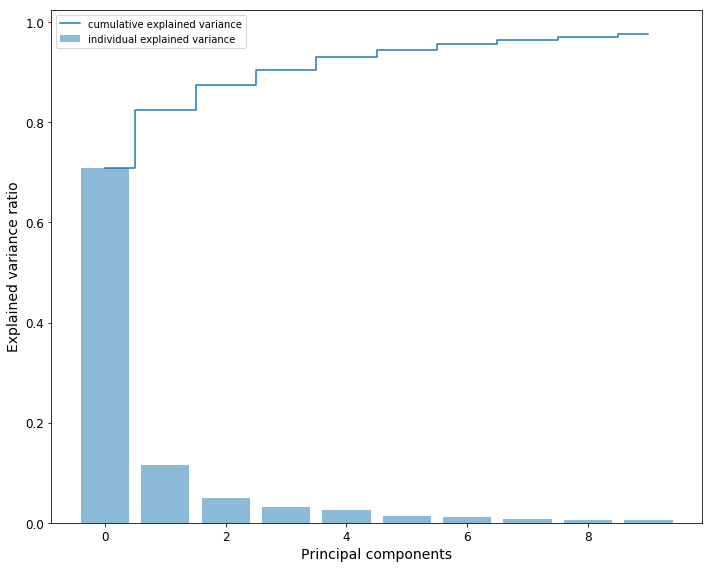

In [8]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
var_exp = pca.explained_variance_ratio_

plt.figure(figsize=(10, 8))
plt.bar(range(10), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(10), cumsum, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
cumsum

array([ 0.70879925,  0.82436384,  0.87434953,  0.90550666,  0.93136086,
        0.94403183,  0.95608054,  0.96383181,  0.97032379,  0.9759194 ])

In [10]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5,6,7,8,9
0,-42.63997,13.91900,-6.83329,-3.39653,11.98036,1.65383,-2.04663,-2.62082,0.01667,-0.76866
1,6.70875,28.83118,4.38106,-20.68132,9.36161,-0.77394,-8.73378,4.29272,-7.86355,10.81762
2,-14.24301,-7.97096,5.04364,-2.40643,5.60716,1.20049,-4.73290,-2.67697,-0.19807,0.71269
3,-55.65441,-4.90879,-0.33054,0.11533,0.22572,0.86717,-0.80400,2.20824,1.18839,0.74671
4,-38.57114,-11.07710,4.30346,-0.38574,3.70408,0.77457,-1.91191,-0.49477,-0.77247,0.10384


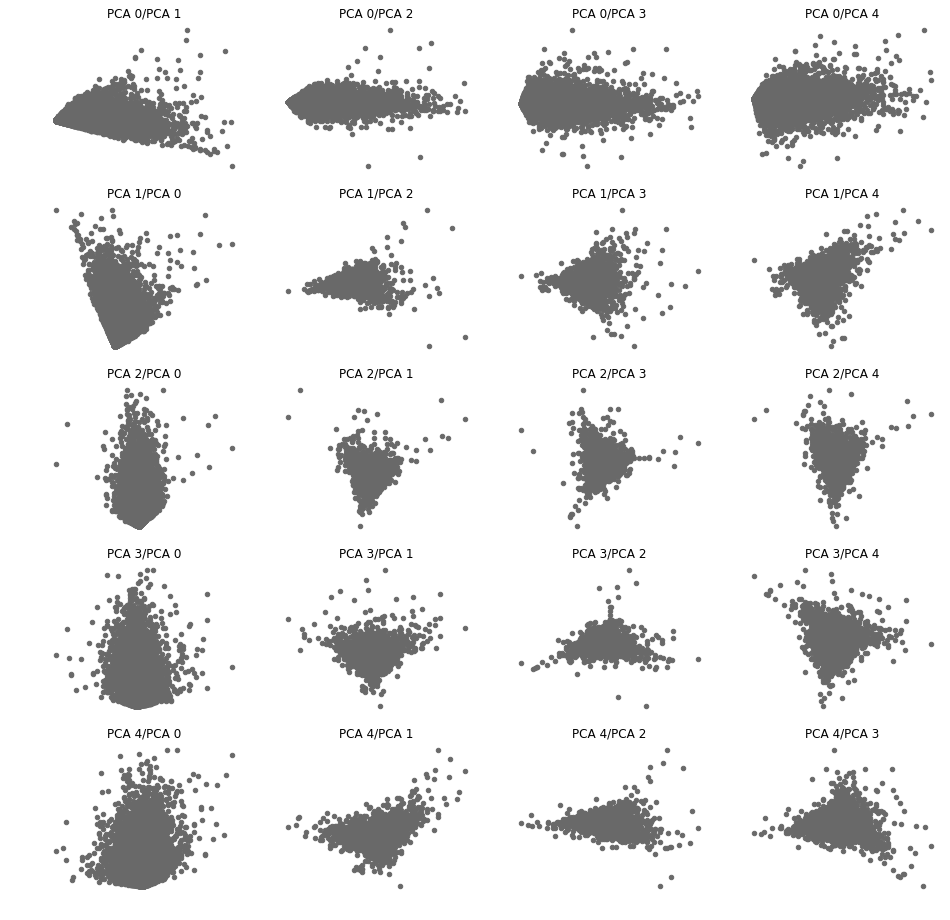

In [11]:
plt.figure(figsize=(16,16))

i=1
for column1 in range(0,5):
    for column2 in range(0,5):
        if column1!=column2:
            ax = plt.subplot(5,4,i)
            ax.scatter(ps[column1], ps[column2], c='dimgrey', s=20)
            plt.axis('off')
            plt.title('PCA {}/PCA {}'.format(column1,column2))
            i+=1
        
plt.show();

There is no obvious cluster separation in the previous plots. Let's try with 3 dimensions, using the first 3 PCA components.

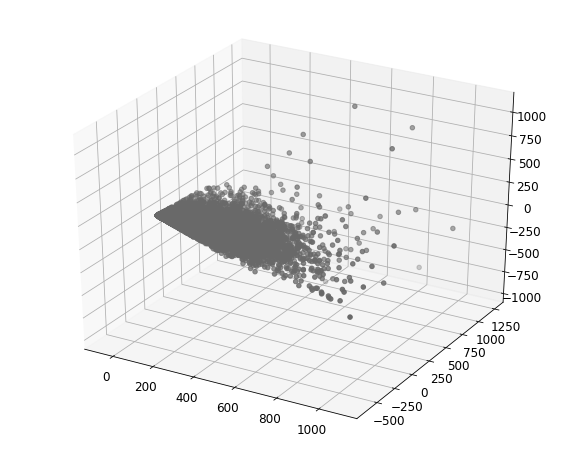

In [12]:
PCA3D = plt.figure(figsize=(10, 8))
ax = PCA3D.add_subplot(111, projection='3d')

ax.scatter(ps[0], ps[1], ps[2], c='dimgray')
plt.show();

Not clear yet. Let's try using all the 10 PCA components to capture 96% of the variance.

In [13]:
#Reduce the matrix for the sake of memory
matDendogram = ps[:10000]

In [14]:
link_mat = linkage(matDendogram, 'ward')
print(link_mat.shape)
clusters = fcluster(link_mat, 10, criterion='maxclust')

(9999, 4)


"Elbow" method for Hierarchical Clustering

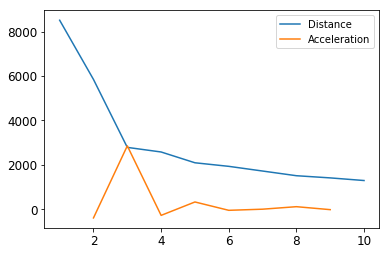

In [15]:
last_merges = link_mat[-10:, 2]
last_merges_rev = last_merges[::-1]
idx = np.arange(1, len(last_merges) + 1)
plt.plot(idx, last_merges_rev, label='Distance')

acceleration = np.diff(last_merges, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idx[:-2] + 1, acceleration_rev, label='Acceleration')
plt.legend()
plt.show()

Now we can see how the distance has an elbow at 3, where also the acceleration has a clear spike, so that could be our number of clusters.

In [16]:
# Find the distance at which to cut off the dendrogram for 
# a given number of clusters
def findDendrogramCut(ddata, n_cluster):
    hierarch_dist = np.matrix(ddata['dcoord'])
    sorted_hierarch_dist = hierarch_dist[np.argsort(hierarch_dist.A[:,1])]
    d_cut = sorted_hierarch_dist[-n_cluster:-n_cluster+2][:,1].sum() / 2.
    return d_cut

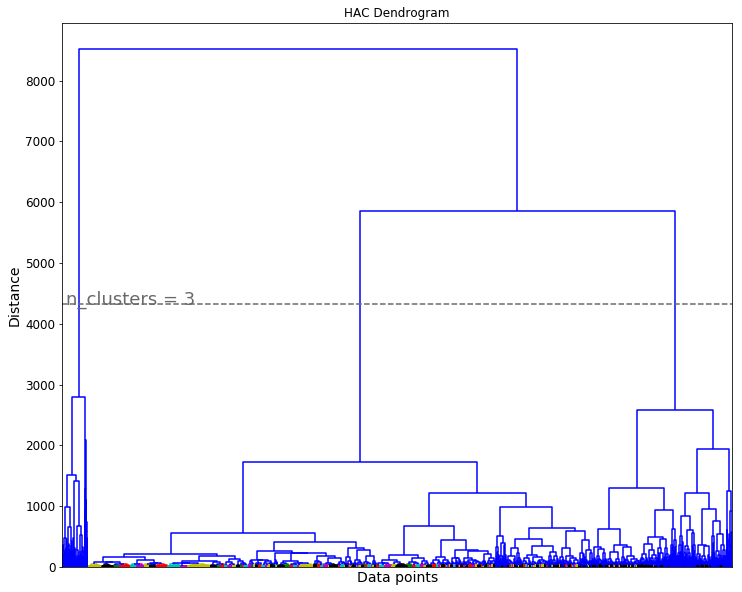

In [17]:
# Plotting a dendrogram
plt.figure(figsize=(12,10))

ddata = dendrogram(link_mat, leaf_rotation=90., no_labels=True, color_threshold=50)
dist_cut = findDendrogramCut(ddata, 3)
plt.axhline(y=dist_cut, linestyle='--', c='dimgray')
plt.text(np.min(ddata['icoord'])*100, dist_cut+2, 'n_clusters = 3', size=18, color='dimgray')
plt.title('HAC Dendrogram',)
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.show();

We can see here too how there is a clear distance gap for 3 clusters, but probably 5 clusters wouldn't be a bad solution based on the dendogram picture.

Let's inspect the inertia of the different number of clusters.

In [18]:
def test(data, nClusterRange):
    inertias = np.zeros(len(nClusterRange))
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++').fit(data)
        inertias[i] = model.inertia_
    return inertias

In [19]:
kRange = range(1,12)
testKmean = test(matDendogram, kRange)

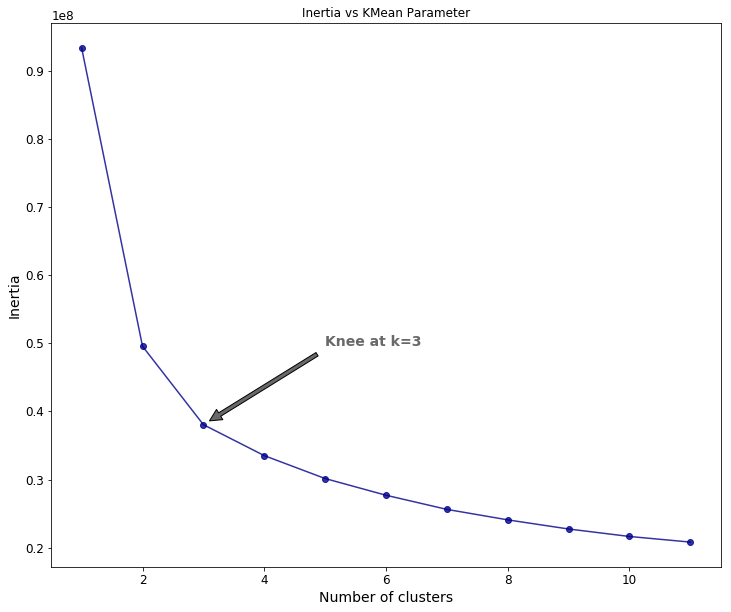

In [20]:
plt.figure(figsize=(12,10))

plt.plot(kRange, testKmean, 'o-', color='darkblue', alpha=0.8)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs KMean Parameter')
plt.annotate('Knee at k=3', xy=(3, testKmean[2]), xytext=(5,testKmean[1]),
             size=14, weight='bold', color='dimgray',
             arrowprops=dict(facecolor='dimgray', shrink=0.05))
plt.show();

Here, it's probably clearer than ever that our cluster number is 3.

### Balancing Inertia with Entropy

In [21]:
# Computing Akaike and Bayes Information Criteria
def kmeansIC(model):
    k, m = model.cluster_centers_.shape
    n, = model.labels_.shape
    D = model.inertia_
    return {'AIC': D + 2*m*k, 'BIC': D + np.log(n)*m*k}

# Computing Renyi and Shannon Entropies
def kmeansRenyi(model):
    n, = model.labels_.shape
    nClusters, m = model.cluster_centers_.shape
    max_p = np.max([ model.labels_[model.labels_ == k].shape[0] for k in range(nClusters)]) / float(n)
    return - np.log2(max_p)

def kmeansEntropy(model):
    n, = model.labels_.shape
    nClusters, m = model.cluster_centers_.shape
    p = np.array([ model.labels_[model.labels_ == k].shape[0] for k in range(nClusters)]) / float(n)
    return - np.sum(p * np.log2(p))

In [22]:
# Small test function to calculate all our model estimators 
# in function of the number of cluster in k-means.
def newTest(data, nClusterRange):
    nClusters = len(nClusterRange)
    inertias = np.zeros(nClusters)
    BICs = np.zeros(nClusters)
    AICs = np.zeros(nClusters)
    Hrenyis = np.zeros(nClusters)
    entropies = np.zeros(nClusters)
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++').fit(data)
        inertias[i] = model.inertia_
        AICs[i] = kmeansIC(model)['AIC']
        BICs[i] = kmeansIC(model)['BIC']
        Hrenyis[i] = kmeansRenyi(model)
        entropies[i] = kmeansEntropy(model)
    return {'inertias': inertias, 'AICs': AICs, 'BICs': BICs, 'Hrenyis': Hrenyis, 'entropies': entropies}

In [23]:
testRes = newTest(matDendogram, range(1,30))

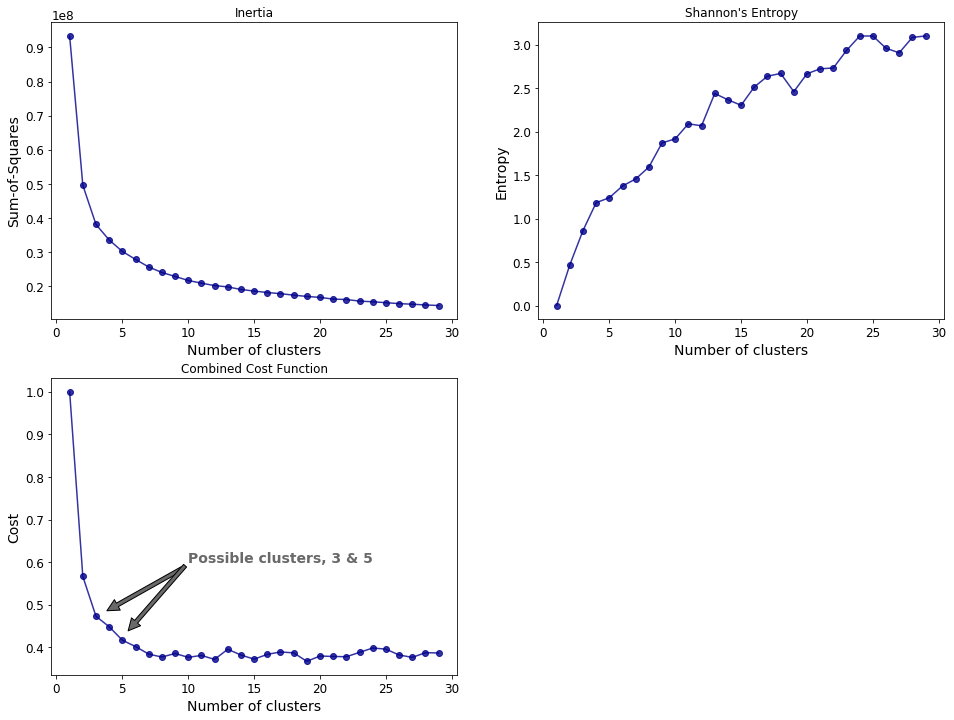

In [24]:
plt.figure(figsize=(16,12))

norm_inertias = testRes['inertias'][0]
norm_entropies = - np.log2(1./len(matDendogram))

ax1 = plt.subplot('221')
ax1.plot(range(1,30),testRes['inertias'], 'o-', color='darkblue', alpha=0.8)
plt.title('Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('Sum-of-Squares')

ax2 = plt.subplot('222')
ax2.plot(range(1,30), testRes['entropies'], 'o-', color='darkblue', alpha=0.8)
plt.title("Shannon's Entropy")
plt.xlabel('Number of clusters')
plt.ylabel('Entropy')

ax3 = plt.subplot('223')
ax3.plot(range(1,30), testRes['inertias']/norm_inertias + testRes['entropies']/norm_entropies, \
         'o-', color='darkblue', alpha=0.8)
plt.title('Combined Cost Function')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')

plt.annotate('Possible clusters, 3 & 5', xy=(3.5, 0.48), xytext=(10, 0.6),
             size=14, weight='bold', color='dimgray',
             arrowprops=dict(facecolor='dimgray', shrink=0.05))
plt.annotate('', xy=(5.2, 0.43), xytext=(10, 0.6),
             size=14, weight='bold', color='dimgray',
             arrowprops=dict(facecolor='dimgray', shrink=0.05))

plt.show();

Based on the combined cost functions, there could be probably 3 or 5 clusters. After that, cost reduction is less important.

## KMeans clusters

From now on, we'll stick with 3 clusters, which was the clearer number of clusters based on the previous analysis.

In [25]:
clusterer = KMeans(n_clusters=3).fit(ps)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(ps)
print(centers)

[[ -3.17403008e+01  -9.50106475e-01   1.19232225e-01  -6.53964078e-02
    3.95783018e-01   1.11186128e-01  -2.01145176e-02   5.01939965e-02
    2.14413051e-02  -2.37549219e-02]
 [  3.15108364e+02  -1.03388423e+01   1.90231052e+00  -6.68490017e-01
    3.38296362e+00   1.83647177e+00  -3.33234229e-01   4.79723558e-01
    5.61818372e-01  -5.86730241e-01]
 [  8.34286516e+01   6.85646065e+00  -9.93798474e-01   4.62423190e-01
   -2.65248478e+00  -9.40521808e-01   1.70369070e-01  -3.47569345e-01
   -2.27158507e-01   2.43796474e-01]]


In [26]:
print (c_preds[0:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 0 2 0]


Here is how our clusters appear

In [27]:
colors = ['blue','green','yellow']
colored = [colors[k] for k in c_preds]

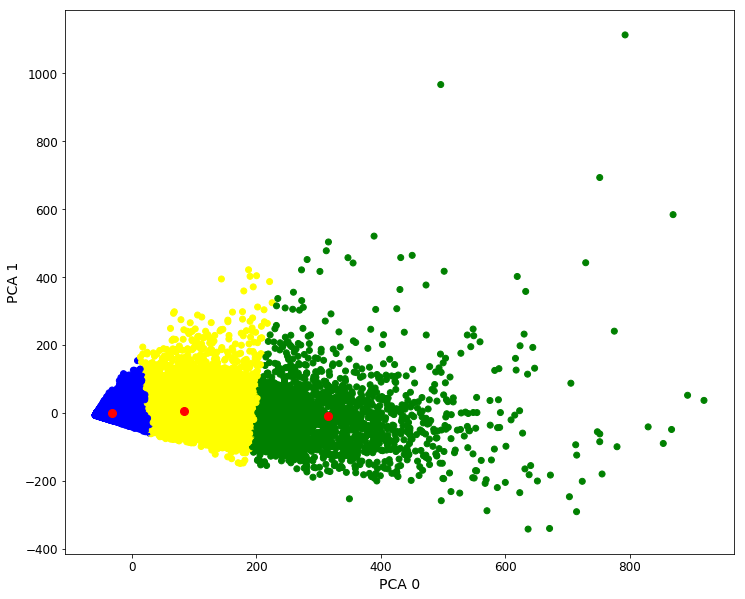

In [28]:
fig = plt.figure(figsize=(12,10))
colors = ['blue','green','yellow']
colored = [colors[k] for k in c_preds]

matXY = ps[[0,1,2]].as_matrix()

plt.scatter(matXY[:50000,0], matXY[:50000,1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red')

plt.xlabel('PCA 0')
plt.ylabel('PCA 1')
plt.show()

PCA 0 must be dominating since the cut between clusters are mostly vertical.

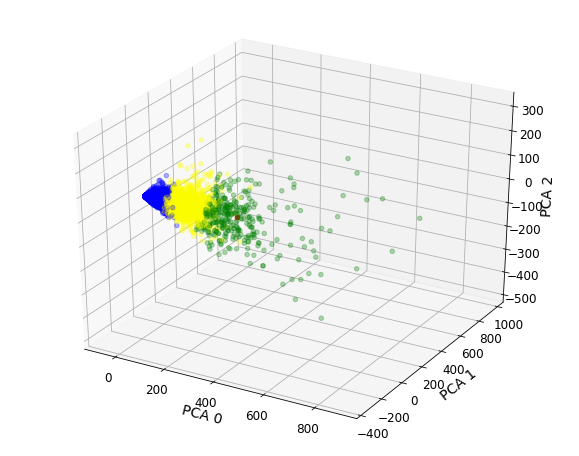

In [29]:
PCA3D = plt.figure(figsize=(10, 8))
ax = PCA3D.add_subplot(111, projection='3d')

matXYZ = ps[[0,1,2]].as_matrix()

ax.scatter(matXYZ[:10000,0], matXYZ[:10000,1], matXYZ[:10000,2], alpha=0.3,color = colored[:10000])

ax.set_xlabel('PCA 0')
ax.set_ylabel('PCA 1')
ax.set_zlabel('PCA 2')

for c in centers:
    ax.scatter(c[0], c[1], c[2], 'o', color='red')
    
plt.show();

Let's finally store the predictions for all the users

In [30]:
df_orders['cluster'] = df_orders.apply(lambda row: c_preds[row.user_id-1], axis=1)

In [31]:
df_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cluster
0,2539329,1,prior,1,2,8,nan,0
1,2398795,1,prior,2,3,7,15.00000,0
2,473747,1,prior,3,3,12,21.00000,0
3,2254736,1,prior,4,4,7,29.00000,0
4,431534,1,prior,5,4,15,28.00000,0


In [32]:
df_orders.to_csv("../data/interim/df_orders_clustered.csv", index_label=False)